# Notebook 04 — Model Training & Evaluation

Train and compare **6 models** on **4 datasets** using **5-fold cross-validation**, then hypertune the best performers.

| # | Model | Type |
|---|-------|------|
| 1 | Logistic / Linear Regression | Baseline |
| 2 | Decision Tree | Tree |
| 3 | Random Forest | Ensemble (bagging) |
| 4 | K-Nearest Neighbors | Instance-based |
| 5 | Gradient Boosting | Ensemble (boosting) |
| 6 | SVM / SVR | Margin-based |

| Dataset | Key |
|---|---|
| Metadata Only | `metadata` |
| Meta + Credits | `meta_credits` |
| Meta + Keywords | `meta_keywords` |
| All Combined | `all` |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib, time
from sklearn.base import clone

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                               GradientBoostingClassifier, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110
print("Libraries loaded.")

Libraries loaded.


## 1 · Load All Dataset Splits

In [3]:
DATASETS = {
    'metadata':      '../data/processed/metadata',
    'meta_credits':  '../data/processed/meta_credits',
    'meta_keywords': '../data/processed/meta_keywords',
    'all':           '../data/processed/all',
}
DS_LABELS = {
    'metadata': 'Metadata Only',
    'meta_credits': 'Meta + Credits',
    'meta_keywords': 'Meta + Keywords',
    'all': 'All Combined',
}

data = {}
for key, path in DATASETS.items():
    data[key] = {
        'X_train_clf': pd.read_csv(f'{path}/X_train_clf.csv'),
        'X_test_clf':  pd.read_csv(f'{path}/X_test_clf.csv'),
        'y_train_clf': pd.read_csv(f'{path}/y_train_clf.csv').squeeze(),
        'y_test_clf':  pd.read_csv(f'{path}/y_test_clf.csv').squeeze(),
        'X_train_reg': pd.read_csv(f'{path}/X_train_reg.csv'),
        'X_test_reg':  pd.read_csv(f'{path}/X_test_reg.csv'),
        'y_train_reg': pd.read_csv(f'{path}/y_train_reg.csv').squeeze(),
        'y_test_reg':  pd.read_csv(f'{path}/y_test_reg.csv').squeeze(),
    }
    d = data[key]
    print(f"{DS_LABELS[key]:20s}  CLF Train: {d['X_train_clf'].shape}  Test: {d['X_test_clf'].shape}"
          f"  |  REG Train: {d['X_train_reg'].shape}  Test: {d['X_test_reg'].shape}")

Metadata Only         CLF Train: (4281, 33)  Test: (1071, 33)  |  REG Train: (4281, 33)  Test: (1071, 33)
Meta + Credits        CLF Train: (4281, 39)  Test: (1071, 39)  |  REG Train: (4281, 39)  Test: (1071, 39)
Meta + Keywords       CLF Train: (4281, 34)  Test: (1071, 34)  |  REG Train: (4281, 34)  Test: (1071, 34)
All Combined          CLF Train: (4281, 40)  Test: (1071, 40)  |  REG Train: (4281, 40)  Test: (1071, 40)


---
## 2 · Classification — Predict `is_profitable`

### 2.1 · Cross-Validate All Models on All Datasets

In [4]:
clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree':       DecisionTreeClassifier(random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN':                 KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM':                 SVC(kernel='rbf', probability=True, random_state=42),
}

all_cv_clf = {}
for ds_key in DATASETS:
    Xtr = data[ds_key]['X_train_clf']
    ytr = data[ds_key]['y_train_clf']
    print(f"\n--- {DS_LABELS[ds_key]} ({Xtr.shape[1]} features) ---")
    print(f"{'Model':<25} {'Accuracy':>10} {'F1':>10} {'ROC-AUC':>10}  Time")
    print("-" * 68)

    cv_res = {}
    for name, model in clf_models.items():
        t0 = time.time()
        m = clone(model)
        acc = cross_val_score(m, Xtr, ytr, cv=5, scoring='accuracy')
        f1 = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='f1')
        auc_s = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='roc_auc')
        elapsed = time.time() - t0

        cv_res[name] = {
            'accuracy': acc.mean(), 'f1': f1.mean(), 'roc_auc': auc_s.mean(),
            'acc_std': acc.std(), 'f1_std': f1.std(), 'auc_std': auc_s.std(),
        }
        print(f"{name:<25} {acc.mean():.4f}±{acc.std():.3f}"
              f" {f1.mean():.4f}±{f1.std():.3f}"
              f" {auc_s.mean():.4f}±{auc_s.std():.3f}"
              f"  {elapsed:.1f}s")
    all_cv_clf[ds_key] = cv_res


--- Metadata Only (33 features) ---
Model                       Accuracy         F1    ROC-AUC  Time
--------------------------------------------------------------------
Logistic Regression       0.7734±0.009 0.8443±0.005 0.8262±0.015  0.1s
Decision Tree             0.7097±0.013 0.7924±0.010 0.6547±0.015  0.3s
Random Forest             0.7881±0.014 0.8554±0.008 0.8350±0.018  2.4s
KNN                       0.7108±0.008 0.8023±0.005 0.7199±0.006  2.5s
Gradient Boosting         0.7886±0.010 0.8553±0.006 0.8409±0.021  6.8s
SVM                       0.7543±0.004 0.8392±0.004 0.7937±0.022  15.1s

--- Meta + Credits (39 features) ---
Model                       Accuracy         F1    ROC-AUC  Time
--------------------------------------------------------------------
Logistic Regression       0.7758±0.008 0.8459±0.005 0.8263±0.015  0.2s
Decision Tree             0.7115±0.004 0.7927±0.003 0.6604±0.006  0.4s
Random Forest             0.7821±0.008 0.8520±0.005 0.8311±0.019  2.2s
KNN              

### 2.2 · CV Results Comparison

BEST CLASSIFIER PER DATASET (by CV F1)
        Dataset        Best Model  CV Accuracy  CV F1  CV ROC-AUC
  Metadata Only     Random Forest       0.7881 0.8554      0.8350
 Meta + Credits Gradient Boosting       0.7884 0.8550      0.8410
Meta + Keywords     Random Forest       0.7870 0.8563      0.8355
   All Combined Gradient Boosting       0.7914 0.8572      0.8422


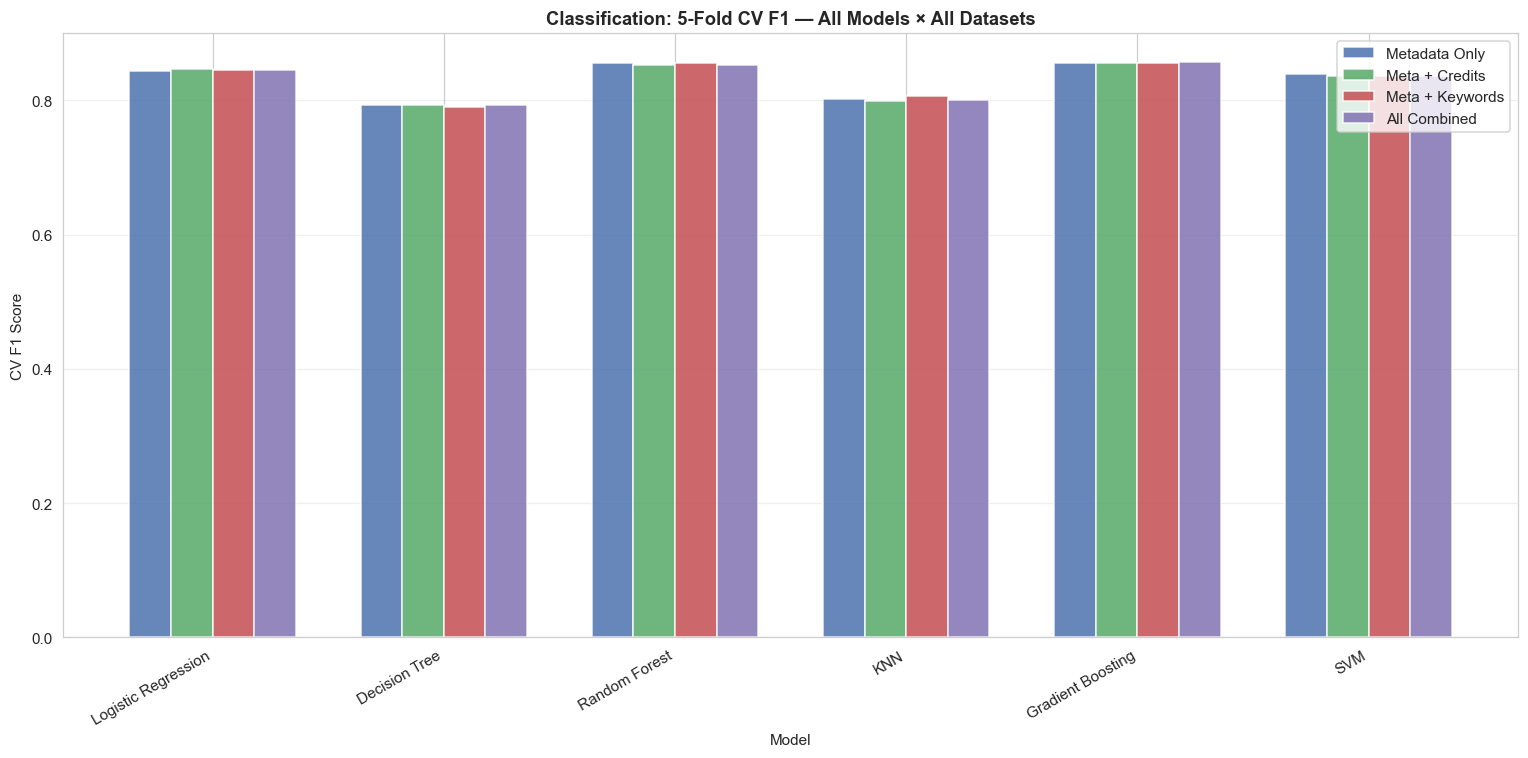

In [5]:
# Best model per dataset (by CV F1)
best_clf_summary = []
for ds_key in DATASETS:
    cv_res = all_cv_clf[ds_key]
    best_name = max(cv_res, key=lambda m: cv_res[m]['f1'])
    best = cv_res[best_name]
    best_clf_summary.append({
        'Dataset': DS_LABELS[ds_key], 'Best Model': best_name,
        'CV Accuracy': round(best['accuracy'], 4),
        'CV F1': round(best['f1'], 4), 'CV ROC-AUC': round(best['roc_auc'], 4),
    })

print("BEST CLASSIFIER PER DATASET (by CV F1)")
print("=" * 80)
print(pd.DataFrame(best_clf_summary).to_string(index=False))

# Grouped bar chart: F1 of all models across datasets
fig, ax = plt.subplots(figsize=(14, 7))
model_names = list(clf_models.keys())
x = np.arange(len(model_names))
width = 0.18
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

for i, ds_key in enumerate(DATASETS):
    f1_vals = [all_cv_clf[ds_key][m]['f1'] for m in model_names]
    ax.bar(x + i * width, f1_vals, width, label=DS_LABELS[ds_key], color=colors[i], alpha=0.85)

ax.set_xlabel('Model')
ax.set_ylabel('CV F1 Score')
ax.set_title('Classification: 5-Fold CV F1 — All Models × All Datasets', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names, rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 · Test Set Evaluation

In [6]:
# Train on full train set, evaluate on test set for each dataset
all_test_clf = {}
for ds_key in DATASETS:
    Xtr = data[ds_key]['X_train_clf']
    Xte = data[ds_key]['X_test_clf']
    ytr = data[ds_key]['y_train_clf']
    yte = data[ds_key]['y_test_clf']

    test_res = {}
    for name, model in clf_models.items():
        m = clone(model)
        m.fit(Xtr, ytr)
        y_pred = m.predict(Xte)
        y_prob = m.predict_proba(Xte)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(Xte)

        test_res[name] = {
            'accuracy': accuracy_score(yte, y_pred),
            'precision': precision_score(yte, y_pred),
            'recall': recall_score(yte, y_pred),
            'f1': f1_score(yte, y_pred),
            'roc_auc': roc_auc_score(yte, y_prob),
        }
    all_test_clf[ds_key] = test_res

# Print results per dataset
for ds_key in DATASETS:
    print(f"\n--- {DS_LABELS[ds_key]} ---")
    test_df = pd.DataFrame(all_test_clf[ds_key]).T
    test_df = test_df.sort_values('f1', ascending=False)
    print(test_df.round(4).to_string())


--- Metadata Only ---
                     accuracy  precision  recall      f1  roc_auc
Gradient Boosting      0.7937     0.8300  0.8865  0.8573   0.8579
Random Forest          0.7908     0.8261  0.8879  0.8559   0.8619
Logistic Regression    0.7750     0.8159  0.8758  0.8448   0.8392
SVM                    0.7563     0.7779  0.9119  0.8396   0.8232
KNN                    0.7264     0.7794  0.8491  0.8128   0.7245
Decision Tree          0.7358     0.8140  0.8064  0.8102   0.6889

--- Meta + Credits ---
                     accuracy  precision  recall      f1  roc_auc
Random Forest          0.7937     0.8220  0.8999  0.8591   0.8507
Gradient Boosting      0.7937     0.8308  0.8852  0.8571   0.8583
Logistic Regression    0.7684     0.8151  0.8652  0.8394   0.8383
SVM                    0.7451     0.7686  0.9092  0.8330   0.8133
KNN                    0.7283     0.7786  0.8545  0.8148   0.7153
Decision Tree          0.7190     0.8094  0.7824  0.7957   0.6769

--- Meta + Keywords ---
    

### 2.4 · Hyperparameter Tuning (Top 2 per Dataset)

In [7]:
param_grids_clf = {
    'Decision Tree': {'max_depth': [3, 5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'KNN': {'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'poly']},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
}

tuned_clf_results = {}
for ds_key in DATASETS:
    cv_df = pd.DataFrame(all_cv_clf[ds_key]).T
    top2 = cv_df['f1'].nlargest(2).index.tolist()
    print(f"\n{'='*70}")
    print(f"Tuning {DS_LABELS[ds_key]}: {top2}")
    print(f"{'='*70}")

    tuned_clf_results[ds_key] = {}
    for name in top2:
        model_class = clf_models[name].__class__
        init_params = {'random_state': 42} if 'random_state' in clf_models[name].get_params() else {}
        grid = GridSearchCV(
            model_class(**init_params),
            param_grids_clf[name], cv=5, scoring='f1', n_jobs=-1, verbose=0
        )
        grid.fit(data[ds_key]['X_train_clf'], data[ds_key]['y_train_clf'])

        y_pred = grid.predict(data[ds_key]['X_test_clf'])
        y_prob = grid.predict_proba(data[ds_key]['X_test_clf'])[:, 1] if hasattr(grid, 'predict_proba') else grid.decision_function(data[ds_key]['X_test_clf'])
        test_f1 = f1_score(data[ds_key]['y_test_clf'], y_pred)

        tuned_clf_results[ds_key][name] = {
            'grid': grid,
            'best_params': grid.best_params_,
            'cv_f1': grid.best_score_,
            'test_f1': test_f1,
            'test_accuracy': accuracy_score(data[ds_key]['y_test_clf'], y_pred),
            'test_roc_auc': roc_auc_score(data[ds_key]['y_test_clf'], y_prob),
        }
        print(f"  {name}: CV F1={grid.best_score_:.4f}, Test F1={test_f1:.4f}")
        print(f"    Best params: {grid.best_params_}")


Tuning Metadata Only: ['Random Forest', 'Gradient Boosting']
  Random Forest: CV F1=0.8577, Test F1=0.8590
    Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  Gradient Boosting: CV F1=0.8553, Test F1=0.8573
    Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Tuning Meta + Credits: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV F1=0.8555, Test F1=0.8534
    Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
  Random Forest: CV F1=0.8580, Test F1=0.8610
    Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Tuning Meta + Keywords: ['Random Forest', 'Gradient Boosting']
  Random Forest: CV F1=0.8584, Test F1=0.8571
    Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
  Gradient Boosting: CV F1=0.8558, Test F1=0.8546
    Best params: {'learning_rate': 0.1, 'max_depth': 3, 

### 2.5 · Select & Save Best Classifier per Dataset

In [8]:
# Select and save best classifier per dataset
os.makedirs('../models', exist_ok=True)
best_clf_models = {}

for ds_key in DATASETS:
    best_name = max(tuned_clf_results[ds_key],
                    key=lambda m: tuned_clf_results[ds_key][m]['test_f1'])
    best_info = tuned_clf_results[ds_key][best_name]
    best_model = best_info['grid'].best_estimator_

    joblib.dump(best_model, f'../models/best_clf_model_{ds_key}.pkl')
    best_clf_models[ds_key] = {
        'name': best_name,
        'test_f1': best_info['test_f1'],
        'test_accuracy': best_info['test_accuracy'],
        'test_roc_auc': best_info['test_roc_auc'],
    }
    print(f"{DS_LABELS[ds_key]:20s} → {best_name}")
    print(f"  F1={best_info['test_f1']:.4f}  Acc={best_info['test_accuracy']:.4f}  AUC={best_info['test_roc_auc']:.4f}")
    print(f"  Saved: models/best_clf_model_{ds_key}.pkl")

Metadata Only        → Random Forest
  F1=0.8590  Acc=0.7918  AUC=0.8617
  Saved: models/best_clf_model_metadata.pkl
Meta + Credits       → Random Forest
  F1=0.8610  Acc=0.7955  AUC=0.8569
  Saved: models/best_clf_model_meta_credits.pkl
Meta + Keywords      → Random Forest
  F1=0.8571  Acc=0.7890  AUC=0.8609
  Saved: models/best_clf_model_meta_keywords.pkl
All Combined         → Gradient Boosting
  F1=0.8596  Acc=0.7983  AUC=0.8599
  Saved: models/best_clf_model_all.pkl


---
## 3 · Regression — Predict `vote_average`

### 3.1 · Cross-Validate All Models on All Datasets

In [9]:
reg_models = {
    'Linear Regression':  LinearRegression(),
    'Decision Tree':      DecisionTreeRegressor(random_state=42),
    'Random Forest':      RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN':                KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting':  GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR':                SVR(kernel='rbf'),
}

all_cv_reg = {}
for ds_key in DATASETS:
    Xtr = data[ds_key]['X_train_reg']
    ytr = data[ds_key]['y_train_reg']
    print(f"\n--- {DS_LABELS[ds_key]} ({Xtr.shape[1]} features) ---")
    print(f"{'Model':<25} {'RMSE':>12} {'MAE':>12} {'R²':>12}  Time")
    print("-" * 75)

    cv_res = {}
    for name, model in reg_models.items():
        t0 = time.time()
        neg_mse = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='neg_mean_squared_error')
        mae_sc  = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='neg_mean_absolute_error')
        r2_sc   = cross_val_score(clone(model), Xtr, ytr, cv=5, scoring='r2')
        elapsed = time.time() - t0

        rmse_vals = np.sqrt(-neg_mse)
        mae_vals  = -mae_sc

        cv_res[name] = {
            'rmse': rmse_vals.mean(), 'rmse_std': rmse_vals.std(),
            'mae': mae_vals.mean(), 'mae_std': mae_vals.std(),
            'r2': r2_sc.mean(), 'r2_std': r2_sc.std(),
        }
        print(f"{name:<25} {rmse_vals.mean():.4f}±{rmse_vals.std():.3f}"
              f" {mae_vals.mean():.4f}±{mae_vals.std():.3f}"
              f" {r2_sc.mean():.4f}±{r2_sc.std():.3f}"
              f"  {elapsed:.1f}s")
    all_cv_reg[ds_key] = cv_res


--- Metadata Only (33 features) ---
Model                             RMSE          MAE           R²  Time
---------------------------------------------------------------------------
Linear Regression         0.7361±0.032 0.5508±0.014 0.3293±0.032  0.1s
Decision Tree             0.9331±0.025 0.6996±0.020 -0.0810±0.085  0.4s
Random Forest             0.6624±0.026 0.4915±0.015 0.4564±0.032  3.0s
KNN                       0.8157±0.030 0.6260±0.014 0.1763±0.033  0.1s
Gradient Boosting         0.6539±0.027 0.4855±0.013 0.4704±0.032  6.8s
SVR                       0.6891±0.041 0.5038±0.021 0.4120±0.047  11.4s

--- Meta + Credits (39 features) ---
Model                             RMSE          MAE           R²  Time
---------------------------------------------------------------------------
Linear Regression         0.7351±0.033 0.5506±0.015 0.3311±0.032  0.1s
Decision Tree             0.9441±0.034 0.7078±0.023 -0.1042±0.060  0.5s
Random Forest             0.6604±0.027 0.4899±0.015 0.4596±0

### 3.2 · CV Results Comparison

BEST REGRESSOR PER DATASET (by CV R²)
        Dataset        Best Model  CV RMSE  CV MAE  CV R²
  Metadata Only Gradient Boosting   0.6539  0.4855 0.4704
 Meta + Credits Gradient Boosting   0.6511  0.4841 0.4749
Meta + Keywords Gradient Boosting   0.6536  0.4850 0.4708
   All Combined Gradient Boosting   0.6497  0.4836 0.4770


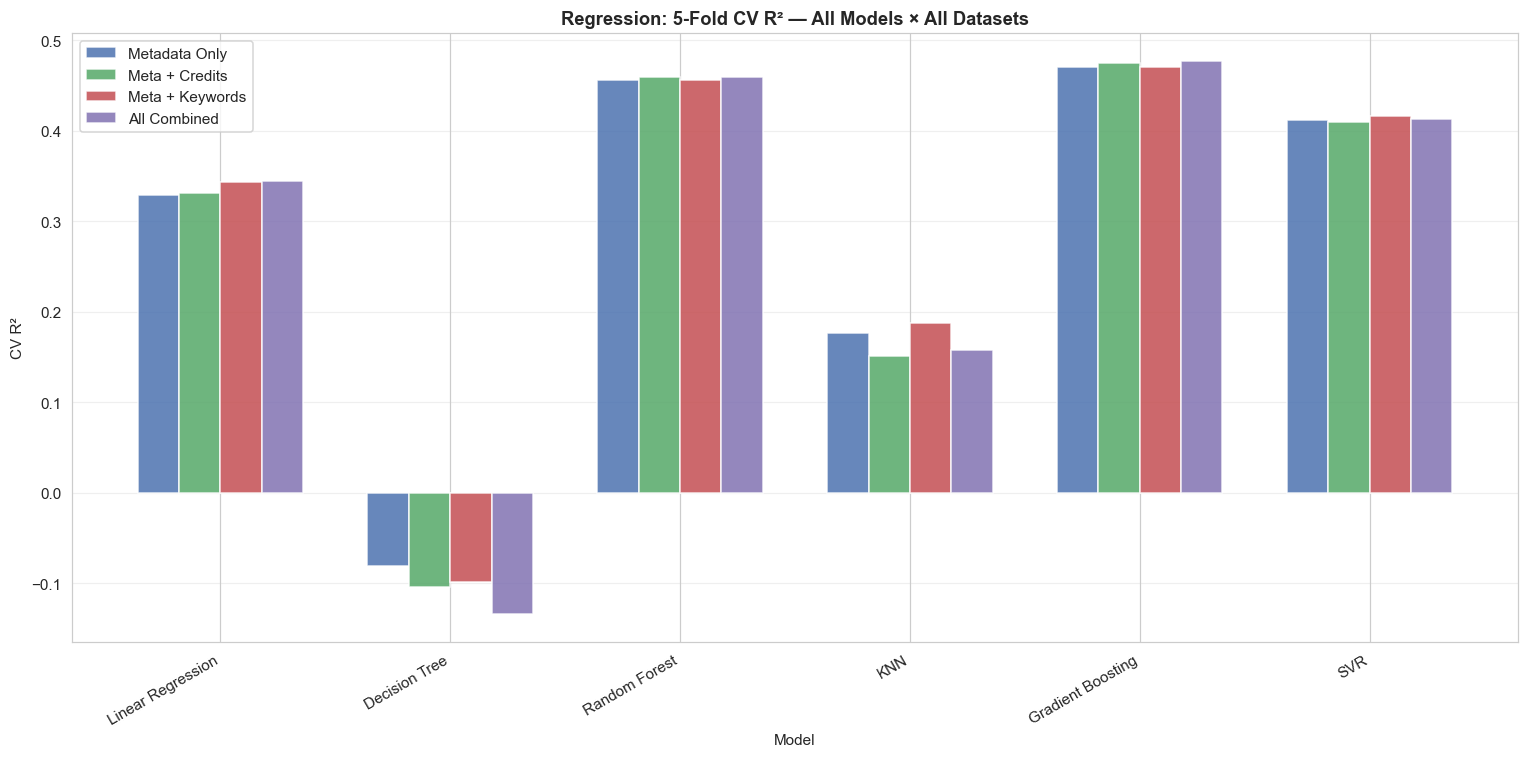

In [10]:
# Best regressor per dataset (by CV R²)
best_reg_summary = []
for ds_key in DATASETS:
    cv_res = all_cv_reg[ds_key]
    best_name = max(cv_res, key=lambda m: cv_res[m]['r2'])
    best = cv_res[best_name]
    best_reg_summary.append({
        'Dataset': DS_LABELS[ds_key], 'Best Model': best_name,
        'CV RMSE': round(best['rmse'], 4),
        'CV MAE': round(best['mae'], 4), 'CV R²': round(best['r2'], 4),
    })

print("BEST REGRESSOR PER DATASET (by CV R²)")
print("=" * 80)
print(pd.DataFrame(best_reg_summary).to_string(index=False))

# Grouped bar chart: R² of all models across datasets
fig, ax = plt.subplots(figsize=(14, 7))
model_names_reg = list(reg_models.keys())
x = np.arange(len(model_names_reg))
width = 0.18

for i, ds_key in enumerate(DATASETS):
    r2_vals = [all_cv_reg[ds_key][m]['r2'] for m in model_names_reg]
    ax.bar(x + i * width, r2_vals, width, label=DS_LABELS[ds_key], color=colors[i], alpha=0.85)

ax.set_xlabel('Model')
ax.set_ylabel('CV R²')
ax.set_title('Regression: 5-Fold CV R² — All Models × All Datasets', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names_reg, rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 · Test Set Evaluation

In [11]:
# Train on full train set, evaluate on test set
all_test_reg = {}
for ds_key in DATASETS:
    Xtr = data[ds_key]['X_train_reg']
    Xte = data[ds_key]['X_test_reg']
    ytr = data[ds_key]['y_train_reg']
    yte = data[ds_key]['y_test_reg']

    test_res = {}
    for name, model in reg_models.items():
        m = clone(model)
        m.fit(Xtr, ytr)
        y_pred = m.predict(Xte)

        test_res[name] = {
            'RMSE': np.sqrt(mean_squared_error(yte, y_pred)),
            'MAE':  mean_absolute_error(yte, y_pred),
            'R²':   r2_score(yte, y_pred),
        }
    all_test_reg[ds_key] = test_res

for ds_key in DATASETS:
    print(f"\n--- {DS_LABELS[ds_key]} ---")
    test_df = pd.DataFrame(all_test_reg[ds_key]).T
    test_df = test_df.sort_values('R²', ascending=False)
    print(test_df.round(4).to_string())


--- Metadata Only ---
                     RMSE     MAE      R²
Gradient Boosting  0.6219  0.4732  0.5002
Random Forest      0.6383  0.4771  0.4735
SVR                0.6487  0.4856  0.4562
Linear Regression  0.6995  0.5434  0.3677
KNN                0.7724  0.5965  0.2290
Decision Tree      0.9311  0.7009 -0.1204

--- Meta + Credits ---
                     RMSE     MAE      R²
Gradient Boosting  0.6222  0.4739  0.4998
Random Forest      0.6318  0.4780  0.4841
SVR                0.6491  0.4838  0.4555
Linear Regression  0.6994  0.5438  0.3679
KNN                0.7987  0.6186  0.1757
Decision Tree      0.9526  0.7205 -0.1727

--- Meta + Keywords ---
                     RMSE     MAE      R²
Gradient Boosting  0.6203  0.4718  0.5027
Random Forest      0.6353  0.4749  0.4785
SVR                0.6449  0.4797  0.4626
Linear Regression  0.6882  0.5320  0.3880
KNN                0.7533  0.5826  0.2667
Decision Tree      0.9081  0.6814 -0.0656

--- All Combined ---
                     RMS

### 3.4 · Hyperparameter Tuning (Top 2 per Dataset)

In [12]:
param_grids_reg = {
    'Decision Tree': {'max_depth': [3, 5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'KNN': {'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'poly']},
    'Linear Regression': {},
}

tuned_reg_results = {}
for ds_key in DATASETS:
    cv_df = pd.DataFrame(all_cv_reg[ds_key]).T
    top2 = cv_df['r2'].nlargest(2).index.tolist()
    print(f"\n{'='*70}")
    print(f"Tuning {DS_LABELS[ds_key]}: {top2}")
    print(f"{'='*70}")

    tuned_reg_results[ds_key] = {}
    for name in top2:
        if not param_grids_reg.get(name):
            print(f"  {name}: No hyperparameters to tune.")
            # Use default model
            m = clone(reg_models[name])
            m.fit(data[ds_key]['X_train_reg'], data[ds_key]['y_train_reg'])
            y_pred = m.predict(data[ds_key]['X_test_reg'])
            tuned_reg_results[ds_key][name] = {
                'model': m,
                'test_rmse': np.sqrt(mean_squared_error(data[ds_key]['y_test_reg'], y_pred)),
                'test_r2': r2_score(data[ds_key]['y_test_reg'], y_pred),
            }
            continue

        model_class = reg_models[name].__class__
        init_params = {'random_state': 42} if 'random_state' in reg_models[name].get_params() else {}
        grid = GridSearchCV(
            model_class(**init_params),
            param_grids_reg[name], cv=5, scoring='r2', n_jobs=-1, verbose=0
        )
        grid.fit(data[ds_key]['X_train_reg'], data[ds_key]['y_train_reg'])

        y_pred = grid.predict(data[ds_key]['X_test_reg'])
        test_rmse = np.sqrt(mean_squared_error(data[ds_key]['y_test_reg'], y_pred))
        test_r2 = r2_score(data[ds_key]['y_test_reg'], y_pred)

        tuned_reg_results[ds_key][name] = {
            'model': grid.best_estimator_,
            'best_params': grid.best_params_,
            'cv_r2': grid.best_score_,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
        }
        print(f"  {name}: CV R²={grid.best_score_:.4f}, Test R²={test_r2:.4f}, Test RMSE={test_rmse:.4f}")
        print(f"    Best params: {grid.best_params_}")


Tuning Metadata Only: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV R²=0.4892, Test R²=0.5197, Test RMSE=0.6096
    Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
  Random Forest: CV R²=0.4628, Test R²=0.4895, Test RMSE=0.6285
    Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Tuning Meta + Credits: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV R²=0.4905, Test R²=0.5117, Test RMSE=0.6147
    Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
  Random Forest: CV R²=0.4644, Test R²=0.4892, Test RMSE=0.6287
    Best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Tuning Meta + Keywords: ['Gradient Boosting', 'Random Forest']
  Gradient Boosting: CV R²=0.4864, Test R²=0.5174, Test RMSE=0.6111
    Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
  Random Forest: CV R²=0.4608, Test R²=0

### 3.5 · Select & Save Best Regressor per Dataset

In [13]:
# Select and save best regressor per dataset
best_reg_models = {}

for ds_key in DATASETS:
    best_name = max(tuned_reg_results[ds_key],
                    key=lambda m: tuned_reg_results[ds_key][m]['test_r2'])
    best_info = tuned_reg_results[ds_key][best_name]
    best_model = best_info['model']

    joblib.dump(best_model, f'../models/best_reg_model_{ds_key}.pkl')
    best_reg_models[ds_key] = {
        'name': best_name,
        'test_rmse': best_info['test_rmse'],
        'test_r2': best_info['test_r2'],
    }
    print(f"{DS_LABELS[ds_key]:20s} → {best_name}")
    print(f"  RMSE={best_info['test_rmse']:.4f}  R²={best_info['test_r2']:.4f}")
    print(f"  Saved: models/best_reg_model_{ds_key}.pkl")

Metadata Only        → Gradient Boosting
  RMSE=0.6096  R²=0.5197
  Saved: models/best_reg_model_metadata.pkl
Meta + Credits       → Gradient Boosting
  RMSE=0.6147  R²=0.5117
  Saved: models/best_reg_model_meta_credits.pkl
Meta + Keywords      → Gradient Boosting
  RMSE=0.6111  R²=0.5174
  Saved: models/best_reg_model_meta_keywords.pkl
All Combined         → Gradient Boosting
  RMSE=0.6091  R²=0.5206
  Saved: models/best_reg_model_all.pkl


---
## 4 · Cross-Dataset Summary

CLASSIFICATION — Best Model per Dataset
        Dataset        Best Model  Test Accuracy  Test F1  Test ROC-AUC
  Metadata Only     Random Forest         0.7918   0.8590        0.8617
 Meta + Credits     Random Forest         0.7955   0.8610        0.8569
Meta + Keywords     Random Forest         0.7890   0.8571        0.8609
   All Combined Gradient Boosting         0.7983   0.8596        0.8599


REGRESSION — Best Model per Dataset
        Dataset        Best Model  Test RMSE  Test R²
  Metadata Only Gradient Boosting     0.6096   0.5197
 Meta + Credits Gradient Boosting     0.6147   0.5117
Meta + Keywords Gradient Boosting     0.6111   0.5174
   All Combined Gradient Boosting     0.6091   0.5206


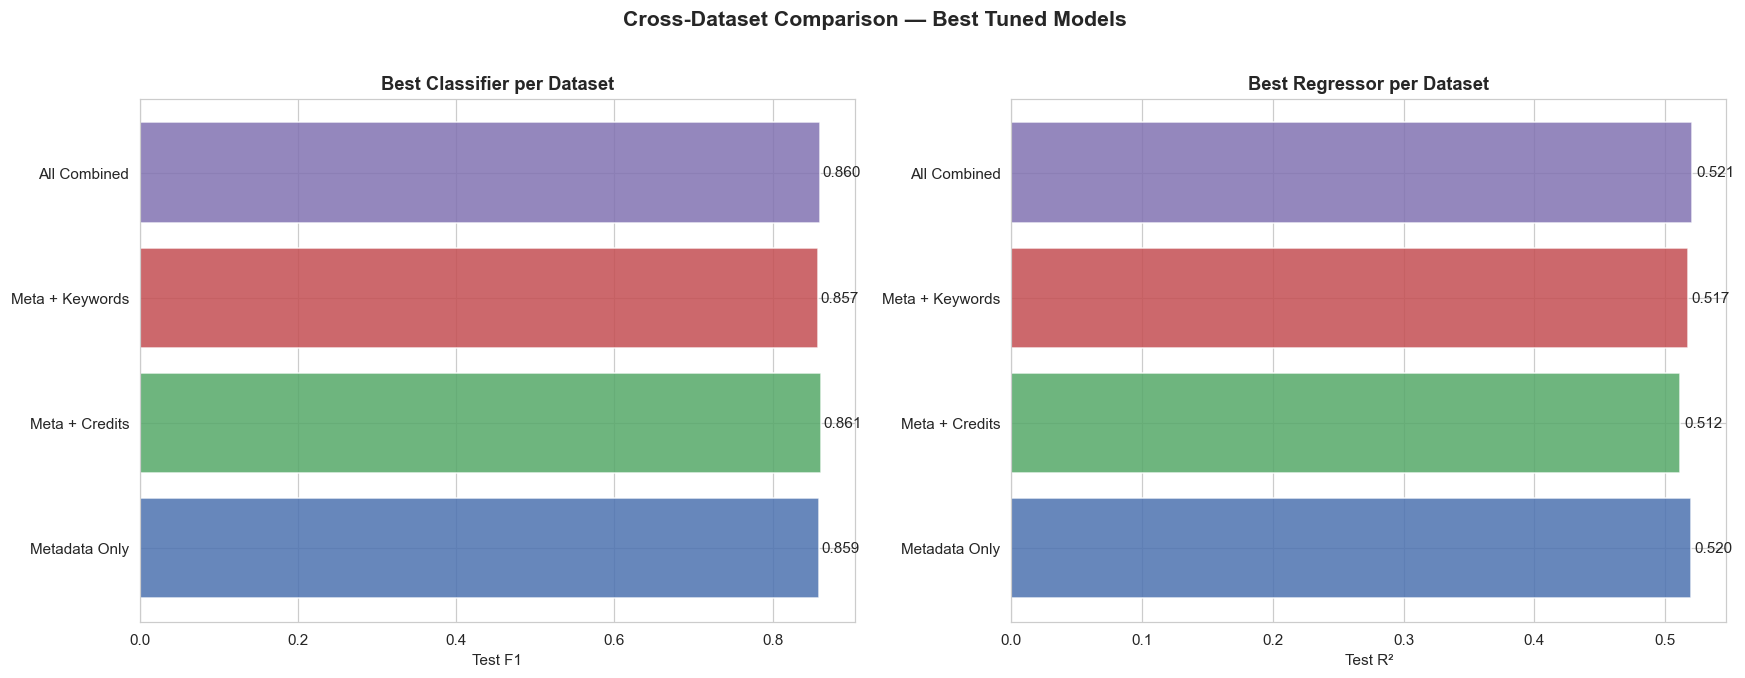

In [14]:
# Final comparison across all datasets
print("CLASSIFICATION — Best Model per Dataset")
print("=" * 80)
clf_comp = []
for ds_key in DATASETS:
    info = best_clf_models[ds_key]
    clf_comp.append({
        'Dataset': DS_LABELS[ds_key],
        'Best Model': info['name'],
        'Test Accuracy': round(info['test_accuracy'], 4),
        'Test F1': round(info['test_f1'], 4),
        'Test ROC-AUC': round(info['test_roc_auc'], 4),
    })
print(pd.DataFrame(clf_comp).to_string(index=False))

print("\n\nREGRESSION — Best Model per Dataset")
print("=" * 80)
reg_comp = []
for ds_key in DATASETS:
    info = best_reg_models[ds_key]
    reg_comp.append({
        'Dataset': DS_LABELS[ds_key],
        'Best Model': info['name'],
        'Test RMSE': round(info['test_rmse'], 4),
        'Test R²': round(info['test_r2'], 4),
    })
print(pd.DataFrame(reg_comp).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ds_labels_list = [DS_LABELS[k] for k in DATASETS]

# Classification F1
f1_vals = [best_clf_models[k]['test_f1'] for k in DATASETS]
axes[0].barh(ds_labels_list, f1_vals, color=colors, alpha=0.85)
axes[0].set_xlabel('Test F1')
axes[0].set_title('Best Classifier per Dataset', fontweight='bold')
for i, v in enumerate(f1_vals):
    axes[0].text(v + 0.003, i, f'{v:.3f}', va='center', fontsize=10)

# Regression R²
r2_vals = [best_reg_models[k]['test_r2'] for k in DATASETS]
axes[1].barh(ds_labels_list, r2_vals, color=colors, alpha=0.85)
axes[1].set_xlabel('Test R²')
axes[1].set_title('Best Regressor per Dataset', fontweight='bold')
for i, v in enumerate(r2_vals):
    axes[1].text(v + 0.003, i, f'{v:.3f}', va='center', fontsize=10)

plt.suptitle('Cross-Dataset Comparison — Best Tuned Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Summary

### Saved Artifacts (per dataset)
| File Pattern | Description |
|------|-------------|
| `models/best_clf_model_{key}.pkl` | Best classifier (is_profitable) per dataset |
| `models/best_reg_model_{key}.pkl` | Best regressor (vote_average) per dataset |
| `models/scaler_clf_{key}.pkl` | StandardScaler for classification features |
| `models/scaler_reg_{key}.pkl` | StandardScaler for regression features |

### Next Steps
1. **Notebook 05** — Advanced improvements (XGBoost, LightGBM, feature selection, class imbalance)
2. Compare improvements across all 4 datasets